In [13]:
from tensorflow.keras.applications import ResNet50

from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import torch
from custom_transformers import *
import tensorflow as tf
import matplotlib.pyplot as plt
from augmentation_generator import *
from sklearn.metrics import confusion_matrix
import seaborn as sns

## Load data

In [3]:
cifar10 = tf.keras.datasets.cifar10

(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
print(f"X_train.shape: {X_train.shape} \nY_train.shape: {Y_train.shape} \nX_test.shape: {X_test.shape} \nY_test.shape: {Y_test.shape}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step
X_train.shape: (50000, 32, 32, 3) 
Y_train.shape: (50000, 1) 
X_test.shape: (10000, 32, 32, 3) 
Y_test.shape: (10000, 1)


## Test Data Generator (with fraction 60% to visualize results)

Adding new samples

In [4]:
random_squares_cutout = RandomSquaresCutout(max_number_of_squares=10,max_size_ratio=0.1,color=False)
generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=16, shuffle=True, augmentor= random_squares_cutout, augment_fraction=0.2, overwrite=False)

batch_x, batch_y = generator[0]

In [5]:
print(batch_x.shape)

(16, 224, 224, 3)


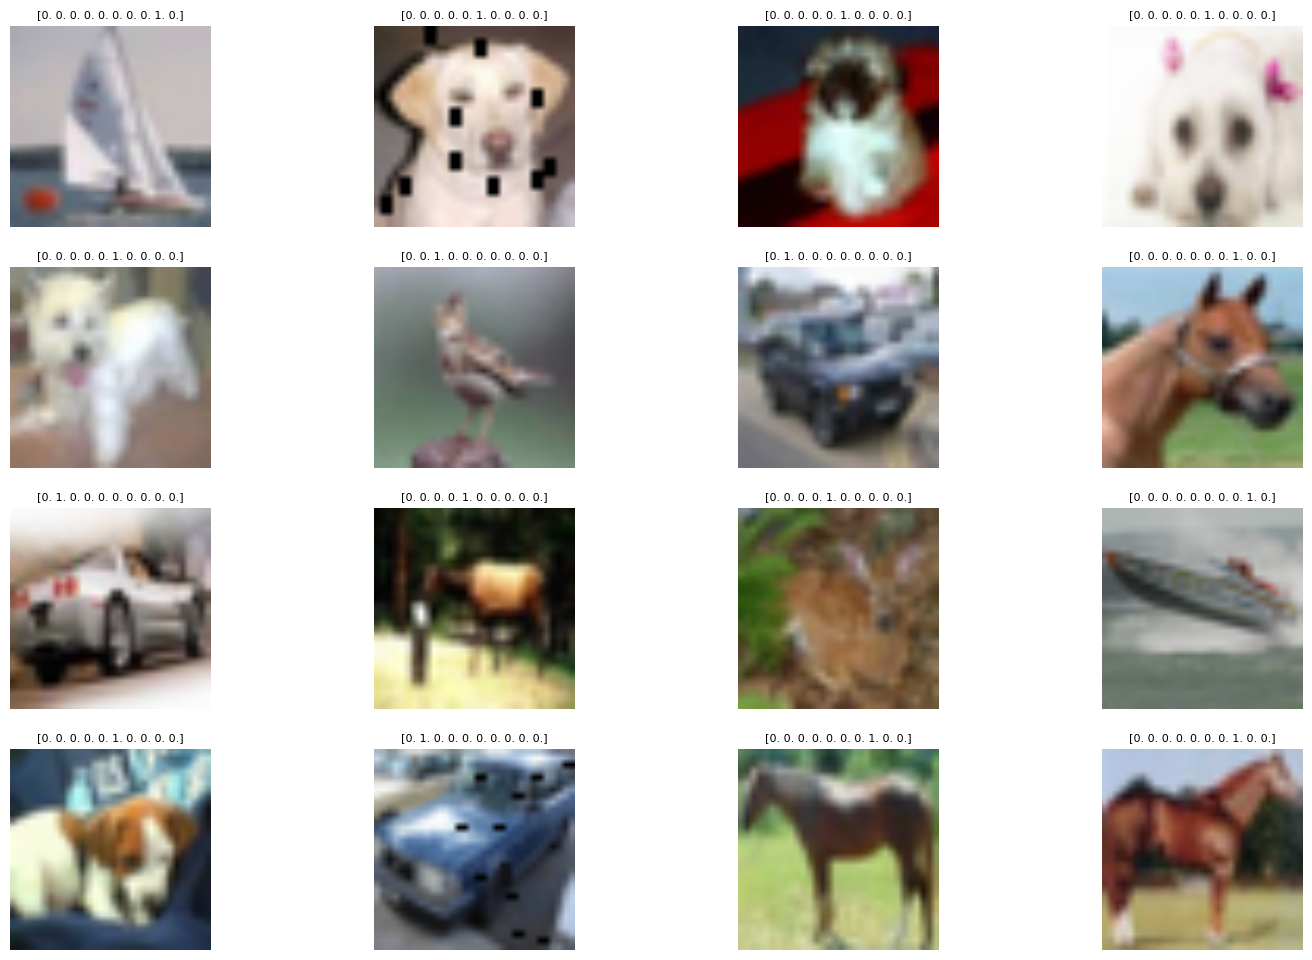

In [6]:
#function to denormalize Restnet preprocessing for visualization purposes
def denormalize_resnet(x):
    x = x.copy()
    x[..., 0] += 103.939  # Blue
    x[..., 1] += 116.779  # Green
    x[..., 2] += 123.68   # Red
    # Zamiana BGR -> RGB
    x = x[..., ::-1]
    x = np.clip(x / 255.0, 0, 1)
    return x

n = len(batch_x)
cols = 4
rows = n//cols + int(n%cols != 0)

fig, axes = plt.subplots(rows, cols, figsize=(18, 12))
if rows == 1 or cols == 1:
    axes = np.expand_dims(axes, axis=0)
for i in range(len(batch_x)):
    row = i // cols
    col = i % cols
    ax = axes[row, col]
    ax.imshow(denormalize_resnet(batch_x[i]))
    ax.set_title(batch_y[i], fontsize=8)
    ax.axis('off')

## Restnet Training - Random Squares

In [7]:
random_squares_cutout = RandomSquaresCutout(max_number_of_squares=10,max_size_ratio=0.1,color=False)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Create generators
train_gen = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=64,
    augmentor=random_squares_cutout, augment_fraction=0.2, overwrite=False)

test_gen = AugmentedCIFAR10Generator(X_test, Y_test,
    batch_size=64, shuffle=False, augmentor=None)


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # Works with both one-hot and soft labels
    metrics=['accuracy']
)

history = model.fit(train_gen, validation_data=test_gen, epochs=5)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


938/938 ━━━━━━━━━━━━━━━━━━━━ 209s 204ms/step - accuracy: 0.7327 - loss: 0.8049 - val_accuracy: 0.8872 - val_loss: 0.3263
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 181s 193ms/step - accuracy: 0.8356 - loss: 0.4739 - val_accuracy: 0.8951 - val_loss: 0.3017
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 208s 221ms/step - accuracy: 0.8459 - loss: 0.4349 - val_accuracy: 0.8932 - val_loss: 0.3051
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 182s 193ms/step - accuracy: 0.8524 - loss: 0.4197 - val_accuracy: 0.9004 - val_loss: 0.2979
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 181s 193ms/step - accuracy: 0.8581 - loss: 0.4038 - val_accuracy: 0.9027 - val_loss: 0.2842


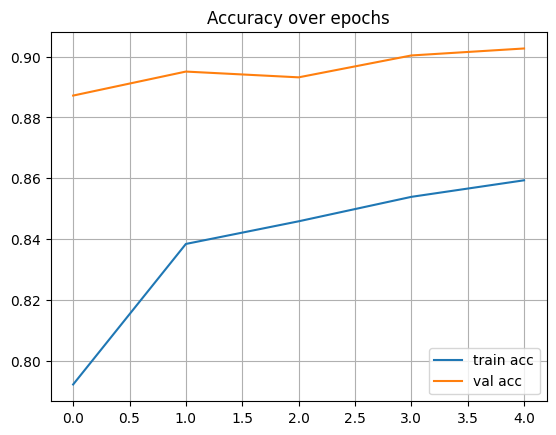

In [12]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Accuracy over epochs")
plt.grid(True)
plt.show()

In [9]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"Accuracy on test set: {test_acc:.2%}")


157/157 ━━━━━━━━━━━━━━━━━━━━ 29s 183ms/step - accuracy: 0.9039 - loss: 0.2807
Accuracy on test set: 90.27%


In [14]:
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(Y_test, axis=1)

#searching for correct and incorrect predictions
correct_indices = np.where(y_pred_classes == y_true)[0]
incorrect_indices = np.where(y_pred_classes != y_true)[0]

157/157 ━━━━━━━━━━━━━━━━━━━━ 34s 195ms/step


In [18]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


<ipython-input-21-87af1e379896>:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actual_label_index = int(Y_test[image_number])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


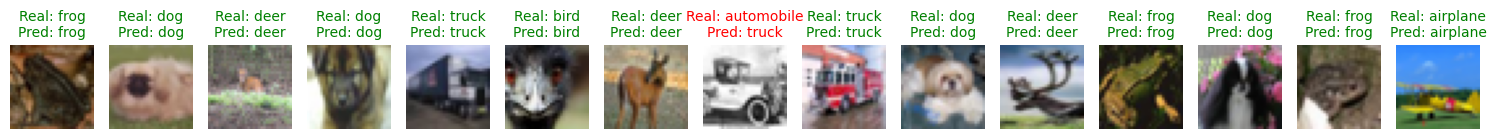

In [21]:
def label_check(image_numbers):
    fig, axes = plt.subplots(1, len(image_numbers), figsize=(15, 5))  # Adjust grid size dynamically

    for i, image_number in enumerate(image_numbers):
        ax = axes[i] if len(image_numbers) > 1 else axes

        image = X_test[image_number]
        ax.imshow(image)
        ax.axis('off')

        #resize and preprocess for ResNet
        image_resized = cv2.resize(image, (224, 224))
        image_preprocessed = preprocess_input(image_resized.astype(np.float32))
        image_input = image_preprocessed.reshape(1, 224, 224, 3)

        predicted_label_index = model.predict(image_input).argmax()
        predicted_label = labels[predicted_label_index]

        actual_label_index = int(Y_test[image_number])
        actual_label = labels[actual_label_index]

        correct = predicted_label_index == actual_label_index
        color = 'green' if correct else 'red'

        ax.set_title(f"Real: {actual_label}\nPred: {predicted_label}", fontsize=10, color=color)

    plt.tight_layout()
    plt.show()
label_check(range(30,45))

In [23]:
model.save("resnet_model_random_squares.keras")
model.save("resnet_model_random_squares.h5")